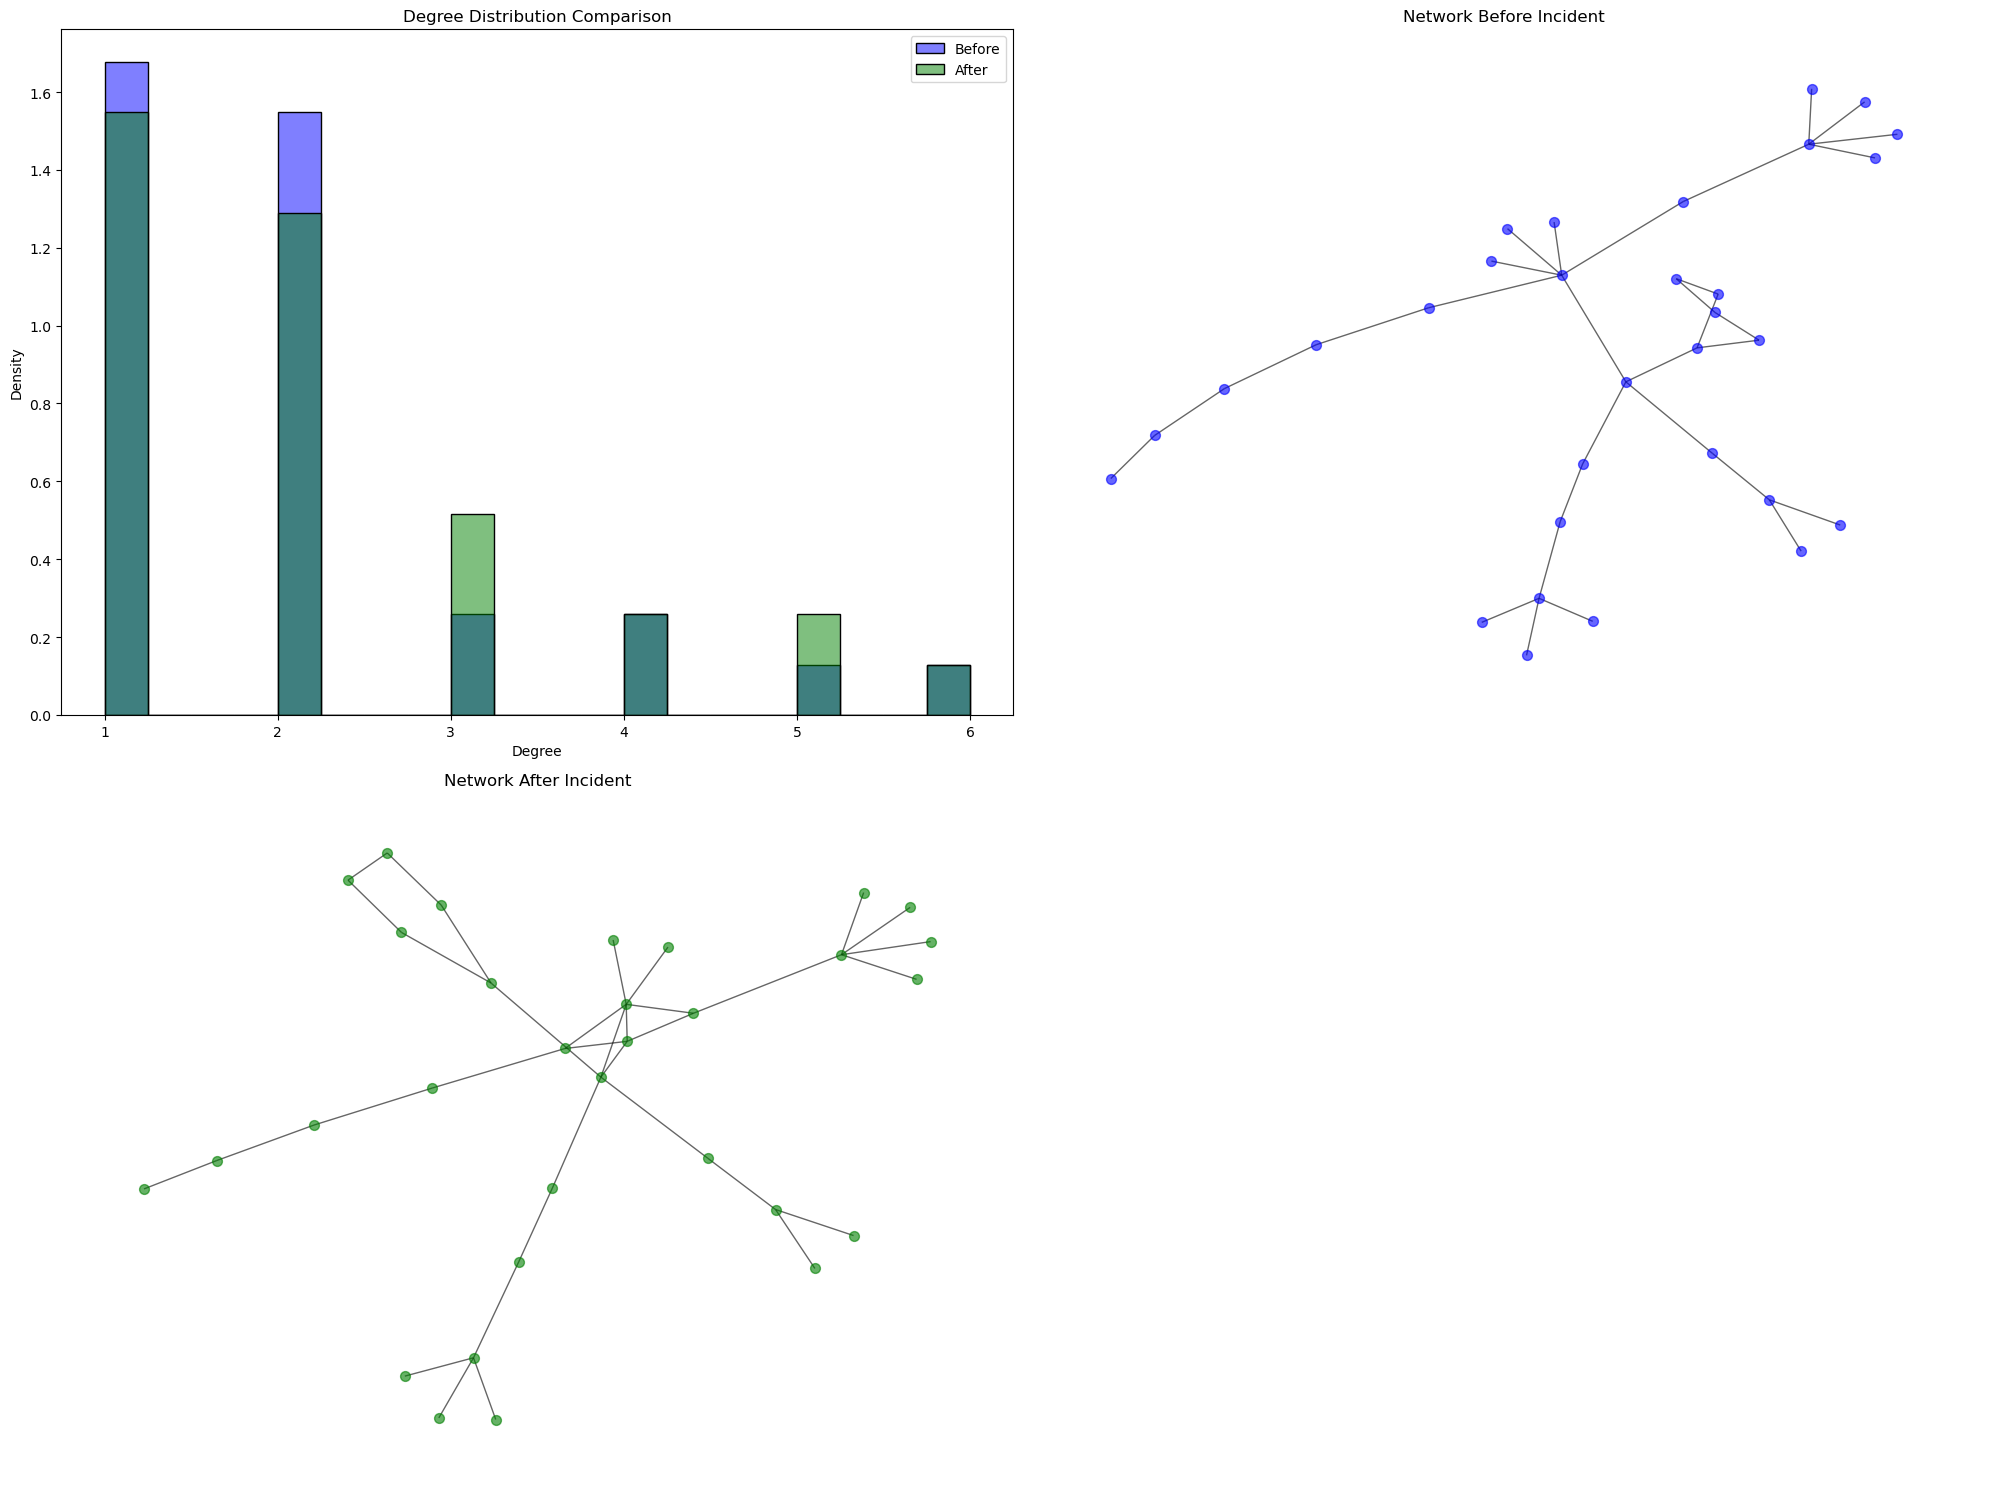

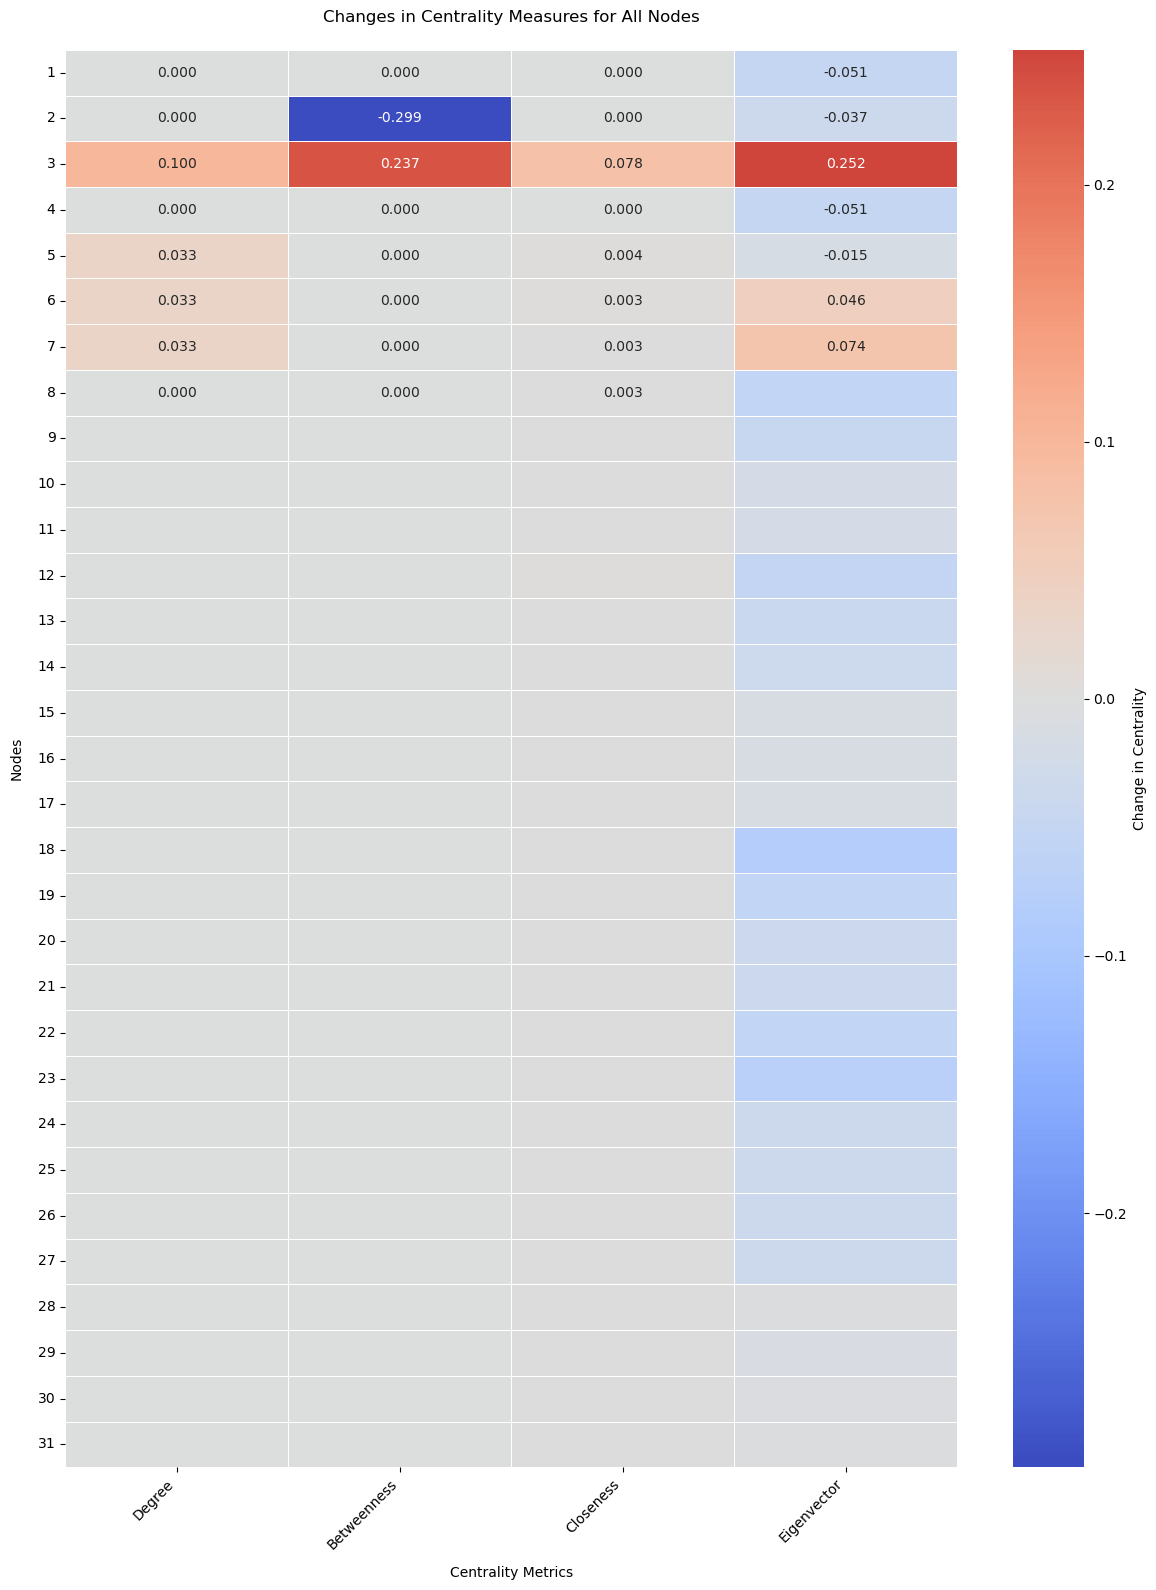


=== Spectral Metrics ===
            Metric   Before    After   Change
   Spectral Radius 2.954881 9.174269 6.219388
Fiedler Eigenvalue 0.057182 0.087386 0.030203

=== Other Network-Level Changes ===
               Metric    Change
   Average Clustering  0.047312
      Network Density  0.006452
       Average Degree  0.193548
           Components  0.000000
  Average Path Length -0.058065
     Network Diameter  0.000000
Number of Communities -1.000000

=== Structural Changes ===
         Structural Change  Value
                 New Nodes      0
             Removed Nodes      0
                 New Edges      3
             Removed Edges      0
Degree Distribution Change      3

=== Anomalous Nodes ===
  Degree  Betweenness  Closeness  Eigenvector  anomaly
0.000000    -0.298851   0.000000    -0.036736       -1
0.100000     0.236782   0.078458     0.252463       -1
0.033333     0.000000   0.004104    -0.015189       -1

=== Additional Metrics ===
K-Core Numbers (After):
2: 2
1: 1
3: 2

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.ensemble import IsolationForest
import seaborn as sns
from typing import Tuple, Dict
import community  # python-louvain package
from collections import Counter
import warnings

# Suppress specific FutureWarnings from Seaborn
warnings.filterwarnings("ignore", category=FutureWarning, module='seaborn')

def load_graph(nodes_file: str, edges_file: str) -> Tuple[nx.Graph, pd.DataFrame, pd.DataFrame]:
    """
    Load network data from CSV files and create a NetworkX graph.

    Parameters:
    - nodes_file: Path to the nodes CSV file.
    - edges_file: Path to the edges CSV file.

    Returns:
    - G: NetworkX graph.
    - nodes_df: DataFrame containing node attributes.
    - edges_df: DataFrame containing edge attributes.
    """
    nodes_df = pd.read_csv(nodes_file)
    edges_df = pd.read_csv(edges_file)
    G = nx.Graph()
    
    # Add node attributes as a dictionary
    node_attrs = nodes_df.set_index('Id').to_dict('index')
    G.add_nodes_from([(node, attrs) for node, attrs in node_attrs.items()])
    
    # Add edges with weights if available
    if 'Weight' in edges_df.columns:
        G.add_weighted_edges_from([(row['Source'], row['Target'], row['Weight']) 
                                 for _, row in edges_df.iterrows()])
    else:
        G.add_edges_from([(row['Source'], row['Target']) 
                         for _, row in edges_df.iterrows()])
    
    return G, nodes_df, edges_df

def calculate_network_metrics(G: nx.Graph) -> Dict:
    """
    Calculate comprehensive network metrics, including spectral radius and Fiedler eigenvalue.

    Parameters:
    - G: NetworkX graph.

    Returns:
    - metrics: Dictionary containing network metrics.
    """
    metrics = {
        'Average Clustering': nx.average_clustering(G),
        'Network Density': nx.density(G),
        'Average Degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
        'Components': nx.number_connected_components(G)
    }
    
    # Check if the graph is connected
    if nx.is_connected(G):
        # Average Path Length and Diameter
        metrics['Average Path Length'] = nx.average_shortest_path_length(G)
        metrics['Network Diameter'] = nx.diameter(G)
        
        # Spectral Radius
        A = nx.adjacency_matrix(G).todense()
        eigvals = np.linalg.eigvals(A)
        spectral_radius = np.max(np.abs(eigvals))
        metrics['Spectral Radius'] = spectral_radius
        
        # Fiedler Eigenvalue
        L = nx.laplacian_matrix(G).todense()
        eigvals_L = np.linalg.eigvalsh(L)  # Since Laplacian is symmetric
        if len(eigvals_L) >= 2:
            fiedler_eigval = eigvals_L[1]
            metrics['Fiedler Eigenvalue'] = fiedler_eigval
        else:
            metrics['Fiedler Eigenvalue'] = np.nan
    else:
        metrics['Average Path Length'] = np.nan
        metrics['Network Diameter'] = np.nan
        metrics['Spectral Radius'] = np.nan
        metrics['Fiedler Eigenvalue'] = np.nan
    
    try:
        communities = community.best_partition(G)
        metrics['Number of Communities'] = len(set(communities.values()))
    except Exception as e:
        print(f"Community detection failed: {e}")
        metrics['Number of Communities'] = np.nan
    
    return metrics

def calculate_node_metrics(G: nx.Graph) -> pd.DataFrame:
    """
    Calculate comprehensive node-level metrics.

    Parameters:
    - G: NetworkX graph.

    Returns:
    - node_metrics_df: DataFrame containing node-level metrics.
    """
    metrics = {
        'Degree Centrality': nx.degree_centrality(G),
        'Betweenness Centrality': nx.betweenness_centrality(G),
        'Closeness Centrality': nx.closeness_centrality(G),
        'Eigenvector Centrality': nx.eigenvector_centrality(G, max_iter=1000),
        'Clustering Coefficient': nx.clustering(G),
        'PageRank': nx.pagerank(G)
    }
    node_metrics_df = pd.DataFrame(metrics).sort_index()
    
    # Compute Fiedler Vector if the graph is connected
    if nx.is_connected(G):
        L = nx.laplacian_matrix(G).todense()
        eigvals_L, eigvecs_L = np.linalg.eig(L)
        idx = eigvals_L.argsort()
        eigvals_L = eigvals_L[idx]
        eigvecs_L = eigvecs_L[:, idx]
        
        if len(eigvals_L) >= 2:
            fiedler_vector = eigvecs_L[:, 1]
            node_metrics_df['Fiedler Vector'] = fiedler_vector
        else:
            node_metrics_df['Fiedler Vector'] = np.nan
    else:
        node_metrics_df['Fiedler Vector'] = np.nan
    
    return node_metrics_df

def analyze_changes(G1: nx.Graph, G2: nx.Graph) -> Dict:
    """
    Analyze structural changes between two network snapshots.

    Parameters:
    - G1: First NetworkX graph.
    - G2: Second NetworkX graph.

    Returns:
    - changes: Dictionary containing structural changes.
    """
    changes = {
        'New Nodes': len(set(G2.nodes()) - set(G1.nodes())),
        'Removed Nodes': len(set(G1.nodes()) - set(G2.nodes())),
        'New Edges': len(set(G2.edges()) - set(G1.edges())),
        'Removed Edges': len(set(G1.edges()) - set(G2.edges())),
    }
    
    degrees1 = Counter(dict(G1.degree()).values())
    degrees2 = Counter(dict(G2.degree()).values())
    changes['Degree Distribution Change'] = sum((degrees2 - degrees1).values())
    
    return changes

def calculate_k_core(G: nx.Graph) -> Dict:
    """Calculate core numbers for the graph."""
    return nx.core_number(G)

def calculate_edge_betweenness(G: nx.Graph) -> Dict[Tuple, float]:
    """Calculate edge betweenness centrality."""
    return nx.edge_betweenness_centrality(G)

def calculate_node_strength(G: nx.Graph) -> Dict:
    """Calculate node strength."""
    node_strength = {}
    for u, v, data in G.edges(data=True):
        weight = data.get('Weight', 1)
        node_strength[u] = node_strength.get(u, 0) + weight
        node_strength[v] = node_strength.get(v, 0) + weight
    return node_strength

def calculate_assortativity(G: nx.Graph) -> float:
    """Calculate degree assortativity coefficient."""
    return nx.degree_assortativity_coefficient(G)

def calculate_local_efficiency(G: nx.Graph) -> float:
    """Calculate average local efficiency."""
    return nx.local_efficiency(G)

def assess_network_robustness(G: nx.Graph, removal_fraction=0.1) -> Dict:
    """Assess network robustness."""
    results = {}
    
    edge_betweenness = nx.edge_betweenness_centrality(G)
    nodes_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
    nodes_to_remove = int(removal_fraction * G.number_of_nodes())
    nodes_removed = [node for node, degree in nodes_sorted[:nodes_to_remove]]
    
    G_temp = G.copy()
    G_temp.remove_nodes_from(nodes_removed)
    if G_temp.number_of_nodes() > 0:
        largest_cc = max(nx.connected_components(G_temp), key=len)
        results['Largest_CC_After_Node_Removal'] = len(largest_cc)
    else:
        results['Largest_CC_After_Node_Removal'] = 0
    
    edges_sorted = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)
    edges_to_remove = int(removal_fraction * G.number_of_edges())
    edges_removed = [edge for edge, centrality in edges_sorted[:edges_to_remove]]
    
    G_temp = G.copy()
    G_temp.remove_edges_from(edges_removed)
    if G_temp.number_of_edges() > 0:
        largest_cc = max(nx.connected_components(G_temp), key=len)
        results['Largest_CC_After_Edge_Removal'] = len(largest_cc)
    else:
        results['Largest_CC_After_Edge_Removal'] = 0
    
    return results

def visualize_network_overview(G1: nx.Graph, G2: nx.Graph, output_folder: str):
    """Create and display network visualization."""
    os.makedirs(output_folder, exist_ok=True)
    
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    
    degrees1 = [d for n, d in G1.degree()]
    degrees2 = [d for n, d in G2.degree()]
    
    degrees1 = [np.nan if np.isinf(d) else d for d in degrees1]
    degrees2 = [np.nan if np.isinf(d) else d for d in degrees2]
    
    sns.histplot(degrees1, color='blue', label='Before', kde=False, stat="density", bins=20, alpha=0.5, ax=axs[0,0])
    sns.histplot(degrees2, color='green', label='After', kde=False, stat="density", bins=20, alpha=0.5, ax=axs[0,0])
    axs[0,0].set_title('Degree Distribution Comparison')
    axs[0,0].set_xlabel('Degree')
    axs[0,0].set_ylabel('Density')
    axs[0,0].legend()
    
    pos_before = nx.spring_layout(G1, seed=42)
    nx.draw(G1, pos_before, node_size=50, alpha=0.6, with_labels=False, node_color='blue', ax=axs[0,1])
    axs[0,1].set_title('Network Before Incident')
    
    pos_after = nx.spring_layout(G2, seed=42)
    nx.draw(G2, pos_after, node_size=50, alpha=0.6, with_labels=False, node_color='green', ax=axs[1,0])
    axs[1,0].set_title('Network After Incident')
    
    axs[1,1].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'network_overview.png'))
    plt.show()
    plt.close()

def visualize_node_metrics_heatmap(centrality_changes: pd.DataFrame, output_folder: str):
    """Create and display heatmap of changes in node metrics."""
    plt.figure(figsize=(12, 16))
    
    sns.heatmap(centrality_changes, 
                annot=True,
                cmap='coolwarm',
                center=0,
                fmt='.3f',
                cbar_kws={'label': 'Change in Centrality'},
                square=False,
                linewidths=0.5)
    
    plt.title('Changes in Centrality Measures for All Nodes', pad=20)
    plt.xlabel('Centrality Metrics', labelpad=10)
    plt.ylabel('Nodes', labelpad=10)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(output_folder, 'node_metrics_changes_heatmap.png'))
    plt.show()
    plt.close()

def display_metrics(spectral_df: pd.DataFrame, other_changes_df: pd.DataFrame,
                   structural_changes_df: pd.DataFrame, anomalies: pd.DataFrame,
                   k_core2: Dict, assortativity1: float, assortativity2: float,
                   local_efficiency1: float, local_efficiency2: float,
                   robustness1: Dict, robustness2: Dict):
    """Display all metrics directly."""
    print("\n=== Spectral Metrics ===")
    print(spectral_df.to_string(index=False))
    
    print("\n=== Other Network-Level Changes ===")
    print(other_changes_df.to_string(index=False))
    
    print("\n=== Structural Changes ===")
    print(structural_changes_df.to_string(index=False))
    
    print("\n=== Anomalous Nodes ===")
    if not anomalies.empty:
        print(anomalies[anomalies['anomaly'] == -1].to_string(index=False))
    else:
        print("No anomalous nodes detected.")
    
    print("\n=== Additional Metrics ===")
    print("K-Core Numbers (After):")
    for node, core in k_core2.items():
        print(f"{node}: {core}")
    
    print("\nDegree Assortativity Coefficient:")
    print(f"Before: {assortativity1:.6f}, After: {assortativity2:.6f}")
    
    print("\nLocal Efficiency:")
    print(f"Before: {local_efficiency1:.6f}, After: {local_efficiency2:.6f}")
    
    print("\nNetwork Robustness:")
    print("Before Removal:")
    for key, value in robustness1.items():
        print(f"  {key}: {value}")
    print("After Removal:")
    for key, value in robustness2.items():
        print(f"  {key}: {value}")

def save_metrics_to_csv(spectral_df: pd.DataFrame, other_changes_df: pd.DataFrame,
                       structural_changes_df: pd.DataFrame, output_folder: str):
    """Save metrics to CSV files."""
    spectral_df.to_csv(os.path.join(output_folder, 'spectral_metrics_changes.csv'), index=False)
    other_changes_df.to_csv(os.path.join(output_folder, 'other_network_changes.csv'), index=False)
    structural_changes_df.to_csv(os.path.join(output_folder, 'structural_changes.csv'), index=False)

def save_anomalies_to_csv(anomalies: pd.DataFrame, output_folder: str):
    """Save anomalies to CSV."""
    anomalies_to_save = anomalies[anomalies['anomaly'] == -1]
    anomalies_to_save.to_csv(os.path.join(output_folder, 'node_metrics_changes.csv'), index=False)

def save_additional_metrics(k_core2: Dict, assortativity1: float, assortativity2: float,
                          local_efficiency1: float, local_efficiency2: float,
                          robustness1: Dict, robustness2: Dict, output_folder: str):
    """Save additional metrics to text file."""
    with open(os.path.join(output_folder, 'additional_metrics.txt'), 'w') as f:
        f.write("=== K-Core Numbers (After) ===\n")
        for node, core in k_core2.items():
            f.write(f"{node}: {core}\n")
        
        f.write("\n=== Degree Assortativity Coefficient ===\n")
        f.write(f"Before: {assortativity1:.6f}, After: {assortativity2:.6f}\n")
        
        f.write("\n=== Local Efficiency ===\n")
        f.write(f"Before: {local_efficiency1:.6f}, After: {local_efficiency2:.6f}\n")
        
        f.write("\n=== Network Robustness ===\n")
        f.write("Before Removal:\n")
        for key, value in robustness1.items():
            f.write(f"  {key}: {value}\n")
        f.write("After Removal:\n")
        for key, value in robustness2.items():
            f.write(f"  {key}: {value}\n")

def create_readme(spectral_df: pd.DataFrame, other_changes_df: pd.DataFrame,
                 structural_changes_df: pd.DataFrame, anomalies: pd.DataFrame,
                 output_folder: str):
    """Create README.md summarizing metrics."""
    readme_path = os.path.join(output_folder, 'README.md')
    with open(readme_path, 'w') as f:
        f.write("# Post-Incident Network Analysis Report\n\n")
        
        f.write("## Network Overview\n\n")
        f.write("![Network Overview](network_overview.png)\n\n")
        
        f.write("## Spectral Metrics\n\n")
        f.write(spectral_df.to_markdown(index=False))
        f.write("\n\n")
        
        f.write("## Other Network-Level Changes\n\n")
        f.write(other_changes_df.to_markdown(index=False))
        f.write("\n\n")
        
        f.write("## Structural Changes\n\n")
        f.write(structural_changes_df.to_markdown(index=False))
        f.write("\n\n")
        
        f.write("## Node Metrics Changes Heatmap\n\n")
        f.write("![Node Metrics Changes Heatmap](node_metrics_changes_heatmap.png)\n\n")
        
        if not anomalies.empty:
            f.write("### Detected Anomalies\n\n")
            f.write(anomalies[anomalies['anomaly'] == -1].to_markdown(index=False))
        else:
            f.write("### No anomalies detected\n")
        f.write("\n\n")
        
        f.write("## Additional Metrics\n\n")
        with open(os.path.join(output_folder, 'additional_metrics.txt'), 'r') as metrics_file:
            f.write(f"```plaintext\n{metrics_file.read()}\n```\n")

def main():
    """Main execution function."""
    input_folder = r'C:\Users\Service Casket\Desktop\Network Analysis Tool\post-incident'
    nodes_file_before = os.path.join(input_folder, 'ICS_OT Nodes.csv')
    edges_file_before = os.path.join(input_folder, 'ICS_OT Edges.csv')
    nodes_file_after = os.path.join(input_folder, 'ICS_OT NodesInfected.csv')
    edges_file_after = os.path.join(input_folder, 'ICS_OT EdgesInfected.csv')
    output_folder = os.path.join(input_folder, 'output')
    os.makedirs(output_folder, exist_ok=True)

    # Load networks
    G1, nodes_df1, edges_df1 = load_graph(nodes_file_before, edges_file_before)
    G2, nodes_df2, edges_df2 = load_graph(nodes_file_after, edges_file_after)

    # Calculate metrics
    network_metrics1 = calculate_network_metrics(G1)
    network_metrics2 = calculate_network_metrics(G2)
    node_metrics1 = calculate_node_metrics(G1)
    node_metrics2 = calculate_node_metrics(G2)

    # Calculate changes
    changes = analyze_changes(G1, G2)
    
    # Calculate additional metrics
    k_core1 = calculate_k_core(G1)
    k_core2 = calculate_k_core(G2)
    edge_betweenness1 = calculate_edge_betweenness(G1)
    edge_betweenness2 = calculate_edge_betweenness(G2)
    node_strength1 = calculate_node_strength(G1)
    node_strength2 = calculate_node_strength(G2)
    assortativity1 = calculate_assortativity(G1)
    assortativity2 = calculate_assortativity(G2)
    local_efficiency1 = calculate_local_efficiency(G1)
    local_efficiency2 = calculate_local_efficiency(G2)
    robustness1 = assess_network_robustness(G1)
    robustness2 = assess_network_robustness(G2)

    # Calculate centrality changes
    centrality_metrics = ['Degree Centrality', 'Betweenness Centrality', 
                         'Closeness Centrality', 'Eigenvector Centrality']
    centrality_changes = node_metrics2[centrality_metrics] - node_metrics1[centrality_metrics]
    centrality_changes.rename(columns={
        'Degree Centrality': 'Degree',
        'Betweenness Centrality': 'Betweenness',
        'Closeness Centrality': 'Closeness',
        'Eigenvector Centrality': 'Eigenvector'
    }, inplace=True)

    # Detect anomalies
    anomalies = centrality_changes.copy()
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    anomalies['anomaly'] = iso_forest.fit_predict(centrality_changes.values)

    # Prepare DataFrames for output
    network_changes = {k: network_metrics2[k] - network_metrics1[k] 
                      for k in network_metrics1.keys()}
    spectral_metrics = ['Spectral Radius', 'Fiedler Eigenvalue']
    spectral_df = pd.DataFrame({
        'Metric': spectral_metrics,
        'Before': [network_metrics1.get(m) for m in spectral_metrics],
        'After': [network_metrics2.get(m) for m in spectral_metrics],
        'Change': [network_changes.get(m) for m in spectral_metrics]
    })

    other_changes_df = pd.DataFrame({
        'Metric': [k for k in network_changes.keys() if k not in spectral_metrics],
        'Change': [v for k, v in network_changes.items() if k not in spectral_metrics]
    })

    structural_changes_df = pd.DataFrame({
        'Structural Change': list(changes.keys()),
        'Value': list(changes.values())
    })

    # Display visualizations and metrics
    visualize_network_overview(G1, G2, output_folder)
    visualize_node_metrics_heatmap(centrality_changes, output_folder)
    display_metrics(spectral_df, other_changes_df, structural_changes_df, 
                   anomalies, k_core2, assortativity1, assortativity2,
                   local_efficiency1, local_efficiency2,
                   robustness1, robustness2)
    
    # Save results
    save_metrics_to_csv(spectral_df, other_changes_df, structural_changes_df, output_folder)
    save_anomalies_to_csv(anomalies, output_folder)
    save_additional_metrics(k_core2, assortativity1, assortativity2,
                          local_efficiency1, local_efficiency2,
                          robustness1, robustness2, output_folder)
    create_readme(spectral_df, other_changes_df, structural_changes_df, 
                 anomalies, output_folder)

if __name__ == "__main__":
    main()